In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

entity-annotated-corpus
wikiner-data




**Importing the dataset for named entity recognition model**

In [2]:
# dframe = pd.read_csv("../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
f=open("../input/wikiner-data/aij-wikiner-fr-wp2.txt", "r")
data=[]
contents =f.readlines()
indx=0
for x in contents:
    words=x.split()
#     print(len(words))
    for i in range(len(words)):
        
        tags=words[i].split("|")
#         print(len(tags))
        data.append([indx,tags[0],tags[2]])
#     print(words)
    indx+=1
wikiner_data= pd.DataFrame(data, columns=['sentence', 'word', 'tag'])

In [3]:
wikiner_data.head(20)

,sentence,word,tag
0,1,Il,O
1,1,assure,O
2,1,à,O
3,1,la,O
4,1,suite,O
5,1,de,I-PER
6,1,Saussure,I-PER
7,1,le,O
8,1,cours,O
9,1,de,O


In [4]:
wikiner_data.head()

,sentence,word,tag
0,1,Il,O
1,1,assure,O
2,1,à,O
3,1,la,O
4,1,suite,O


> **Create list of list of tuples to differentiate each sentence from each other**

In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                       
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(wikiner_data)

In [7]:
sentences = getter.sentences

In [8]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 242


In [9]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

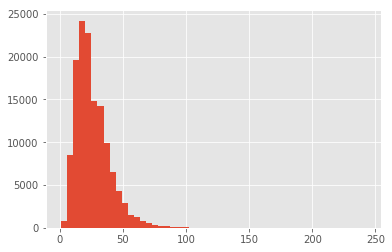

In [10]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
words = list(set(wikiner_data["word"].values))
words.append("ENDPAD")

In [12]:
n_words = len(words); n_words

116487

In [13]:
tags = list(set(wikiner_data["tag"].values))

In [14]:
n_tags = len(tags); n_tags

9

**Converting words to numbers and numbers to words**

In [15]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [17]:
X = pad_sequences(maxlen=242, sequences=X, padding="post",value=n_words - 1)

In [18]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [19]:
y = pad_sequences(maxlen=242, sequences=y, padding="post", value=tag2idx["O"])

In [20]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [23]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ly3g6z4o
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ly3g6z4o
  Stored in directory: /tmp/pip-ephem-wheel-cache-rvjh6qmj/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
input = Input(shape=(242,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=242, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)

In [25]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 242)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 242, 20)           2329760   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 242, 100)          28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 242, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 242, 9)            558       
Total params: 2,363,768
Trainable params: 2,363,768
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Train on 85818 samples, validate on 21455 samples
Epoch 1/5
85818/85818 [==============================] - 1165s 14ms/step - loss: 0.0246 - crf_viterbi_accuracy: 0.9908 - val_loss: 0.0110 - val_crf_viterbi_accuracy: 0.9951
Epoch 2/5
85818/85818 [==============================] - 1160s 14ms/step - loss: 0.0080 - crf_viterbi_accuracy: 0.9964 - val_loss: 0.0076 - val_crf_viterbi_accuracy: 0.9966
Epoch 3/5
 1056/85818 [..............................] - ETA: 17:41 - loss: 0.0061 - crf_viterbi_accuracy: 0.9975

In [27]:
# i = 1
# p = model.predict(np.array([X_test[i]]))
# p = np.argmax(p, axis=-1)
# print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
# for w,pred in zip(X_test[i],p[0]):
#     print("{:15}: {}".format(words[w],tags[pred]))

In [28]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

26819/26819 [==============================] - 81s 3ms/step


In [29]:
!pip install seqeval

  Stored in directory: /tmp/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [30]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [31]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 83.6%


In [32]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 757kB 4.2MB/s 


In [33]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00        13
      B-MISC       0.00      0.00      0.00        10
       B-ORG       0.00      0.00      0.00         3
       B-PER       0.00      0.00      0.00        18
       I-LOC       0.90      0.87      0.88     31051
      I-MISC       0.76      0.75      0.75     16164
       I-ORG       0.80      0.78      0.79      9314
       I-PER       0.91      0.95      0.93     25969
           O       1.00      1.00      1.00   6407656

    accuracy                           1.00   6490198
   macro avg       0.49      0.48      0.48   6490198
weighted avg       1.00      1.00      1.00   6490198

